In [76]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nbformat

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [77]:
%run 'one_hot.ipynb'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [78]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")


tf.config.experimental.set_memory_growth(gpus[0], True)



GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
number of GPU device:  1


In [79]:
fasta_file = os.path.join('..','repertoire','shm','shm_default.fasta')
annotation_file = os.path.join('..','repertoire','shm','shm_default.tsv')

In [80]:
# pad the sequence and get the input
def process_input(sequences,chunk_size):
    """
    To ensure every sequence has the same length, I pad the sequence with "N" up to the length of set chunk_size
    Then encode every sequence to get the final input for the model
    input: a list of raw sequences and chunk size
    output: the input of model (X)
    """
    padded_seq = []
    pad = ''
    for seq in sequences:
        pad = seq.ljust(chunk_size, 'N')
        padded_seq.append(pad)
    
    combined_sequence = ''.join(padded_seq)
    one_hot_sequences = one_hot_encode(combined_sequence) 
   
    return one_hot_sequences

In [81]:
chunk_size=450
sequences = input_file(fasta_file)
X = process_input(sequences,chunk_size)
X.shape

/tmp/ipykernel_735454/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(4500000, 5)

In [82]:
df = pd.read_csv(annotation_file, sep='\t', header=0)
chunk_size=450
VDJ_seq = []
VDJ_num = []
for i in range(len(df)):
    seq = translate_output(df,i)
    seq_num = output_catogory(seq)
    VDJ_seq.append(seq)
    VDJ_num.append(seq_num)
        
combined_vdj = ''.join(VDJ_seq)
encoded_vdj = output_encoding(combined_vdj)

/tmp/ipykernel_735454/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_735454/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [83]:
print(len(combined_vdj))
print(encoded_vdj.shape)
y = encoded_vdj

4500000
(4500000, 5)


In [84]:
train_data_ratio = 0.8 # Choose 80% of the data for training
data_len = len(X)
train_data_len = int(data_len*train_data_ratio)
train_x = X[:train_data_len]
train_y = y[:train_data_len]
test_x = X[train_data_len:]
test_y = y[train_data_len:]

In [85]:
timesteps = 450  

train_x_tensor = np.array([train_x[i:i+timesteps] for i in range(0, train_x.shape[0]-timesteps+1, timesteps)])
train_y_tensor = np.array([train_y[i:i+timesteps] for i in range(0, train_y.shape[0]-timesteps+1, timesteps)])
test_x_tensor = np.array([test_x[i:i+timesteps] for i in range(0, test_x.shape[0]-timesteps+1, timesteps)])
test_y_tensor = np.array([test_y[i:i+timesteps] for i in range(0, test_y.shape[0]-timesteps+1, timesteps)])


In [86]:
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, Lambda, Bidirectional
from tensorflow.keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
import datetime
from keras.layers import Dense, Dropout, LSTM, Embedding, Activation, Lambda, Bidirectional
from tensorflow.keras.layers import TimeDistributed
import time

In [87]:

sequence_length = 450
one_hot_length = 5
input_shape = (sequence_length, one_hot_length)
num_classes = 5
RNN_HIDDEN_DIM = 64
DROPOUT_RATIO = 0.5

model = Sequential()

# First, add the CNN layers for feature extraction
model.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(Dropout(DROPOUT_RATIO))
model.add(Conv1D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1))

# Then, reshape the output from CNN layers to fit the LSTM layer
model.add(TimeDistributed(Flatten())) 

# Followed by the LSTM layers
model.add(Bidirectional(LSTM(units=RNN_HIDDEN_DIM, return_sequences=True)))
model.add(Dropout(DROPOUT_RATIO))
model.add(Bidirectional(LSTM(units=RNN_HIDDEN_DIM, return_sequences=True)))

# Lastly, add a TimeDistributed Dense layer for output
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


2023-08-05 16:03:50.329161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 16:03:50.329770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 16:03:50.330374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 450, 16)           176       
                                                                 
 dropout_5 (Dropout)         (None, 450, 16)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 450, 8)            264       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 450, 8)           0         
 1D)                                                             
                                                                 
 time_distributed_6 (TimeDis  (None, 450, 8)           0         
 tributed)                                                       
                                                                 
 bidirectional_6 (Bidirectio  (None, 450, 128)        

In [88]:
import time

In [89]:
start_time = time.time()
log_dir = "logs/hybrid_shm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_x_tensor, train_y_tensor, validation_data = (test_x_tensor, test_y_tensor), epochs=150, batch_size=64, callbacks=[tf_callback])
end_time = time.time()
training_time = end_time - start_time
print("Training the model took {:.2f} seconds".format(training_time))

Epoch 1/150


2023-08-05 16:03:53.354418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 16:03:53.355246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 16:03:53.355833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.8685

2023-08-05 16:03:59.552290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 16:03:59.553246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 16:03:59.553830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - 7s 39ms/step - loss: 0.3857 - accuracy: 0.8685 - val_loss: 0.1241 - val_accuracy: 0.9482
Epoch 2/150
125/125 [==============================] - 5s 42ms/step - loss: 0.1254 - accuracy: 0.9463 - val_loss: 0.1138 - val_accuracy: 0.9522
Epoch 3/150
125/125 [==============================] - 7s 55ms/step - loss: 0.0912 - accuracy: 0.9600 - val_loss: 0.0648 - val_accuracy: 0.9715
Epoch 4/150
125/125 [==============================] - 5s 43ms/step - loss: 0.0680 - accuracy: 0.9693 - val_loss: 0.0582 - val_accuracy: 0.9743
Epoch 5/150
125/125 [==============================] - 7s 56ms/step - loss: 0.0632 - accuracy: 0.9715 - val_loss: 0.0567 - val_accuracy: 0.9739
Epoch 6/150
125/125 [==============================] - 6s 52ms/step - loss: 0.0602 - accuracy: 0.9727 - val_loss: 0.0523 - val_accuracy: 0.9765
Epoch 7/150
125/125 [==============================] - 7s 54ms/step - loss: 0.0600 - accuracy: 0.9729 - val_loss: 0.0520 - val_accuracy: 0.9769
Epoc

In [90]:
y_pred = model.predict(test_x_tensor)
print(y_pred.shape)
print(test_y_tensor.shape)

2023-08-05 16:39:45.517454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 16:39:45.518153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 16:39:45.519198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 5/63 [=>............................] - ETA: 0s 

2023-08-05 16:39:45.726325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-05 16:39:45.746306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 16:39:45.746903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

63/63 [==============================] - 1s 13ms/step
(2000, 450, 5)
(2000, 450, 5)


In [91]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

([<matplotlib.axis.YTick at 0x7f6f08529950>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

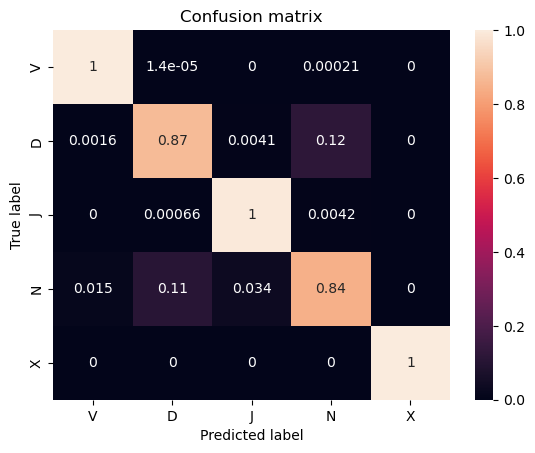

In [92]:
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(test_y_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [94]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9908077777777777
Precision: 0.9468940557036263
Recall: 0.9427827588468665
F1 Score: 0.944738248365085


## new shm dataset

In [49]:
fasta_file = os.path.join('..','repertoire','shm','shm_default_2000.fasta')
annotation_file = os.path.join('..','repertoire','shm','shm_default_2000.tsv')

In [50]:
sequences = input_file(fasta_file)
X_shm = process_input(sequences,chunk_size)
X_shm.shape

/tmp/ipykernel_735454/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(900000, 5)

In [51]:
df = pd.read_csv(annotation_file, sep='\t', header=0)
chunk_size=450
VDJ_seq = []
VDJ_num = []
for i in range(len(df)):
    seq = translate_output(df,i)
    seq_num = output_catogory(seq)
    VDJ_seq.append(seq)
    VDJ_num.append(seq_num)
        
combined_vdj = ''.join(VDJ_seq)
encoded_vdj = output_encoding(combined_vdj)

/tmp/ipykernel_735454/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_735454/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [52]:
print(len(combined_vdj))
print(encoded_vdj.shape)
y_shm = encoded_vdj

900000
(900000, 5)


In [53]:
timesteps = 450  

X_shm_tensor = np.array([X_shm[i:i+timesteps] for i in range(0, X_shm.shape[0]-timesteps+1, timesteps)])
y_shm_tensor = np.array([y_shm[i:i+timesteps] for i in range(0, y_shm.shape[0]-timesteps+1, timesteps)])


In [54]:
y_pred = model.predict(X_shm_tensor)
print(y_pred.shape)
print(y_shm_tensor.shape)

63/63 [==============================] - 1s 21ms/step
(2000, 450, 5)
(2000, 450, 5)


([<matplotlib.axis.YTick at 0x7f6e8c68fb90>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

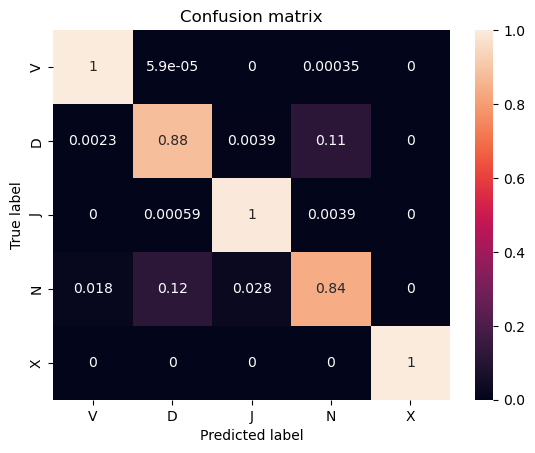

In [55]:
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_shm_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

In [56]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9905955555555556
Precision: 0.9451500773235916
Recall: 0.9422943289912876
F1 Score: 0.9435268121310534


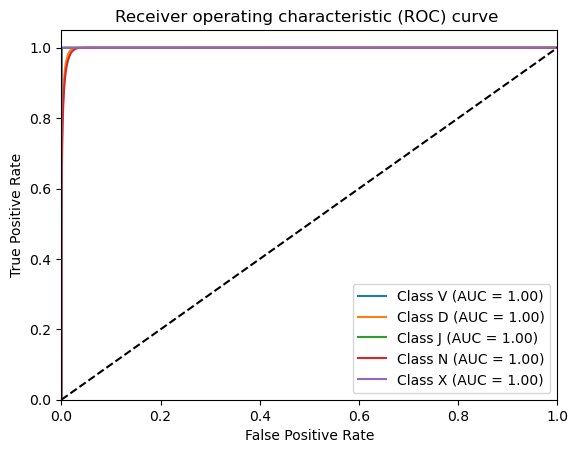

In [57]:
vdjclass = ["V","D","J","N","X"]
plt.figure()
for i in range(5):
    y_pred_1d = y_pred[:,:,i].ravel()
    y_true_1d = y_shm_tensor[:,:,i].ravel()
    fpr, tpr, _ = roc_curve(y_true_1d, y_pred_1d)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Class %s (AUC = %0.2f)' % (vdjclass[i],roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve ')
plt.legend(loc="lower right")
plt.show()

## new nonshm dataset

In [40]:
fasta_file = os.path.join('..','repertoire','first_1000.fasta')
annotation_file = os.path.join('..','repertoire','first_1000.tsv')

In [41]:
sequences = input_file(fasta_file)
X_nonshm = process_input(sequences,chunk_size)
X_nonshm.shape

/tmp/ipykernel_735454/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(450000, 5)

In [42]:
df = pd.read_csv(annotation_file, sep='\t', header=0)
chunk_size=450
VDJ_seq = []
VDJ_num = []
for i in range(len(df)):
    seq = translate_output(df,i)
    seq_num = output_catogory(seq)
    VDJ_seq.append(seq)
    VDJ_num.append(seq_num)
        
combined_vdj = ''.join(VDJ_seq)
encoded_vdj = output_encoding(combined_vdj)

/tmp/ipykernel_735454/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_735454/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [43]:
print(len(combined_vdj))
print(encoded_vdj.shape)
y_nonshm = encoded_vdj

450000
(450000, 5)


In [44]:
timesteps = 450  

X_nonshm_tensor = np.array([X_nonshm[i:i+timesteps] for i in range(0, X_nonshm.shape[0]-timesteps+1, timesteps)])
y_nonshm_tensor = np.array([y_nonshm[i:i+timesteps] for i in range(0, y_nonshm.shape[0]-timesteps+1, timesteps)])


In [45]:
y_pred = model.predict(X_nonshm_tensor)
print(y_pred.shape)
print(y_nonshm_tensor.shape)

32/32 [==============================] - 0s 13ms/step
(1000, 450, 5)
(1000, 450, 5)


([<matplotlib.axis.YTick at 0x7f6e8c415e90>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

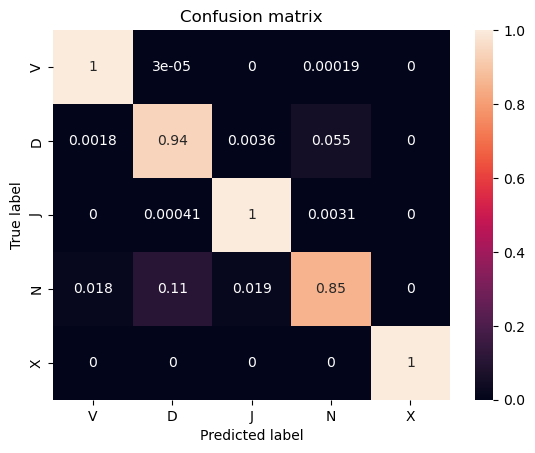

In [46]:
pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_nonshm_tensor,axis=-1)
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N','X'])
labels = ['V', 'D', 'J', 'N','X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

In [47]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9927377777777778
Precision: 0.959668586600112
Recall: 0.9581885007652049
F1 Score: 0.9582167316282089


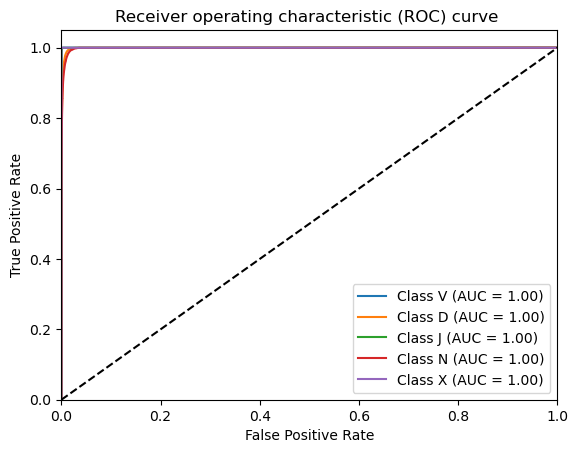

In [48]:
vdjclass = ["V","D","J","N","X"]
plt.figure()
for i in range(5):
    y_pred_1d = y_pred[:,:,i].ravel()
    y_true_1d = y_nonshm_tensor[:,:,i].ravel()
    fpr, tpr, _ = roc_curve(y_true_1d, y_pred_1d)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Class %s (AUC = %0.2f)' % (vdjclass[i],roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve ')
plt.legend(loc="lower right")
plt.show()